In [2]:
import pandas as pd
import seaborn as sns
import subprocess # to call the C++ executable that actually does the network analysis
import glob # to work with files later on
import bidirec_script # for input/formatting

In [3]:
# threshold Nepal network to only significant flows
# this gets rid of the random noise that is an artifact of the gravity model,
# which creates many edges with very low weights (i.e., very little trade)
# use same level that I used in the bidirectional flows, but I can easily change and rerun it with different thresholds
# right now dropping edge weights < 3 (a bit more than the bottom half)
np = pd.read_csv('networks/nepal.txt')
# print(np['weight'].describe())
np.drop(np[np['weight'] < 3].index, inplace=True)
np.to_csv('networks/nepal_significant.txt', index=False)

In [4]:
#### this cell: convert Nepal network to correct format ####
df = bidirec_script.read_file('networks/nepal_significant.txt', ',', 0, 1, 3)
# first, change source/destination names to ints because that is the format expected by the C++ program
df['source_id'] = pd.Categorical(df['source']).codes
# get map of all sources and their ids
locations = {}
for index, data in df.iterrows():
    if data['source'] not in locations.keys():
        locations[data['source']] = data['source_id']
# now, go through the targets in the dataframe and create their destination int id
dests = []
newindex = len(locations.keys())
for index, data in df.iterrows():
    if data['target'] in locations.keys():
        dests.append(locations[data['target']])
    else:
        locations[data['target']] = newindex
        dests.append(newindex)
        newindex += 1
# now add that as dest_id to the original df
df['dest_id'] = dests
# drop unnecessary columns
newdf = df.drop(['source', 'target'], axis=1)
# and rearrange the columns to source_id, dest_id, timestamps
cols = newdf.columns.tolist()
time = cols[0]
cols.pop(0)
cols.append(time)
newdf = newdf[cols]
dfs_all_deltas = []
for i in range(1, 13):
    dfs_all_deltas.append(bidirec_script.dup_edges(newdf, i, 12))
# now save all of these to files for analysis
for d in range(len(dfs_all_deltas)):
    dfs_all_deltas[d].to_csv(path_or_buf= 'input/nepal_d_{num}.txt'.format(num=d+1), sep=' ', header=False, index=False)

In [5]:
# run the C++ file on the correct Nepal net
for i in range(1, 13):
    process = subprocess.Popen(["./FAST_temporal_motif", "-input", "input/nepal_d_{num}.txt".format(num=i), "-output", "output/nepal_out_d_{num}.txt".format(num=i), "-timesOut", "output/nepal_times_d_{num}.txt".format(num=i), "-w", "{num}".format(num=i)])

edgeNum: 1786
inserting...
sorting...
loaded file
edgeNum: 1921
inserting...
sorting...
loaded file
edgeNum: 2056
inserting...
sorting...
loaded file
edgeNum: 2191
inserting...
sorting...
loaded file
edgeNum: 2321
inserting...
sorting...
loaded file
edgeNum: 2370
inserting...
sorting...
loaded file
edgeNum: 2419
inserting...
sorting...
loaded file
edgeNum: 2611
inserting...
sorting...
loaded file
edgeNum: 2803
inserting...
sorting...
loaded file
edgeNum: 2995
inserting...
sorting...
loaded file
edgeNum: 3166
inserting...
sorting...
loaded file
edgeNum: 3302
inserting...
sorting...
loaded file


In [6]:
# then get that output, save it as a dateframe appropriately for analysis
# list of dataframes of the outputs for analysis
# cols: column 1: motif number (0-36), column 2: time at which the motif occurred
# column 3: count of how many times that motif occurred at that time
# column4: delta within which we were counting
df_times = []
for name in glob.glob("output/nepal_times_d_?*.txt"):
    npgraph = pd.read_csv(name)
    df_times.append(npgraph)
df_times = pd.concat(df_times)
print(df_times)

     motif  time  count  delta
0        0     1      0      6
1        0     2      0      6
2        0     3      0      6
3        0     4      0      6
4        0     5      0      6
..     ...   ...    ...    ...
427     35     8   2725     10
428     35     9   1817     10
429     35    10    777     10
430     35    11    112     10
431     35    12   2822     10

[5184 rows x 4 columns]


In [7]:
# finally graph the output for the motifs
df_times = df_times.groupby(['motif', 'time', 'delta']).sum().reset_index()
# below is the counts for all motifs, while I want a plot for each motif
# old way of doing this
# sns.lineplot(data=df_times, x='time', y='count', hue='delta', legend='full')
print(df_times)


      motif  time  delta  count
0         0     1      1      0
1         0     1      2      0
2         0     1      3      0
3         0     1      4      0
4         0     1      5      0
...     ...   ...    ...    ...
5179     35    12      8    371
5180     35    12      9   2056
5181     35    12     10   2822
5182     35    12     11   3375
5183     35    12     12   3375

[5184 rows x 4 columns]


In [8]:
# add matrix position colums to make plotting look better and correspond with motif matrix
df_times['c'] = df_times.apply(lambda row: row.motif % 6, axis = 1)
df_times['r'] = df_times.apply(lambda row: row.motif // 6, axis = 1)
print(df_times)

      motif  time  delta  count  c  r
0         0     1      1      0  0  0
1         0     1      2      0  0  0
2         0     1      3      0  0  0
3         0     1      4      0  0  0
4         0     1      5      0  0  0
...     ...   ...    ...    ... .. ..
5179     35    12      8    371  5  5
5180     35    12      9   2056  5  5
5181     35    12     10   2822  5  5
5182     35    12     11   3375  5  5
5183     35    12     12   3375  5  5

[5184 rows x 6 columns]


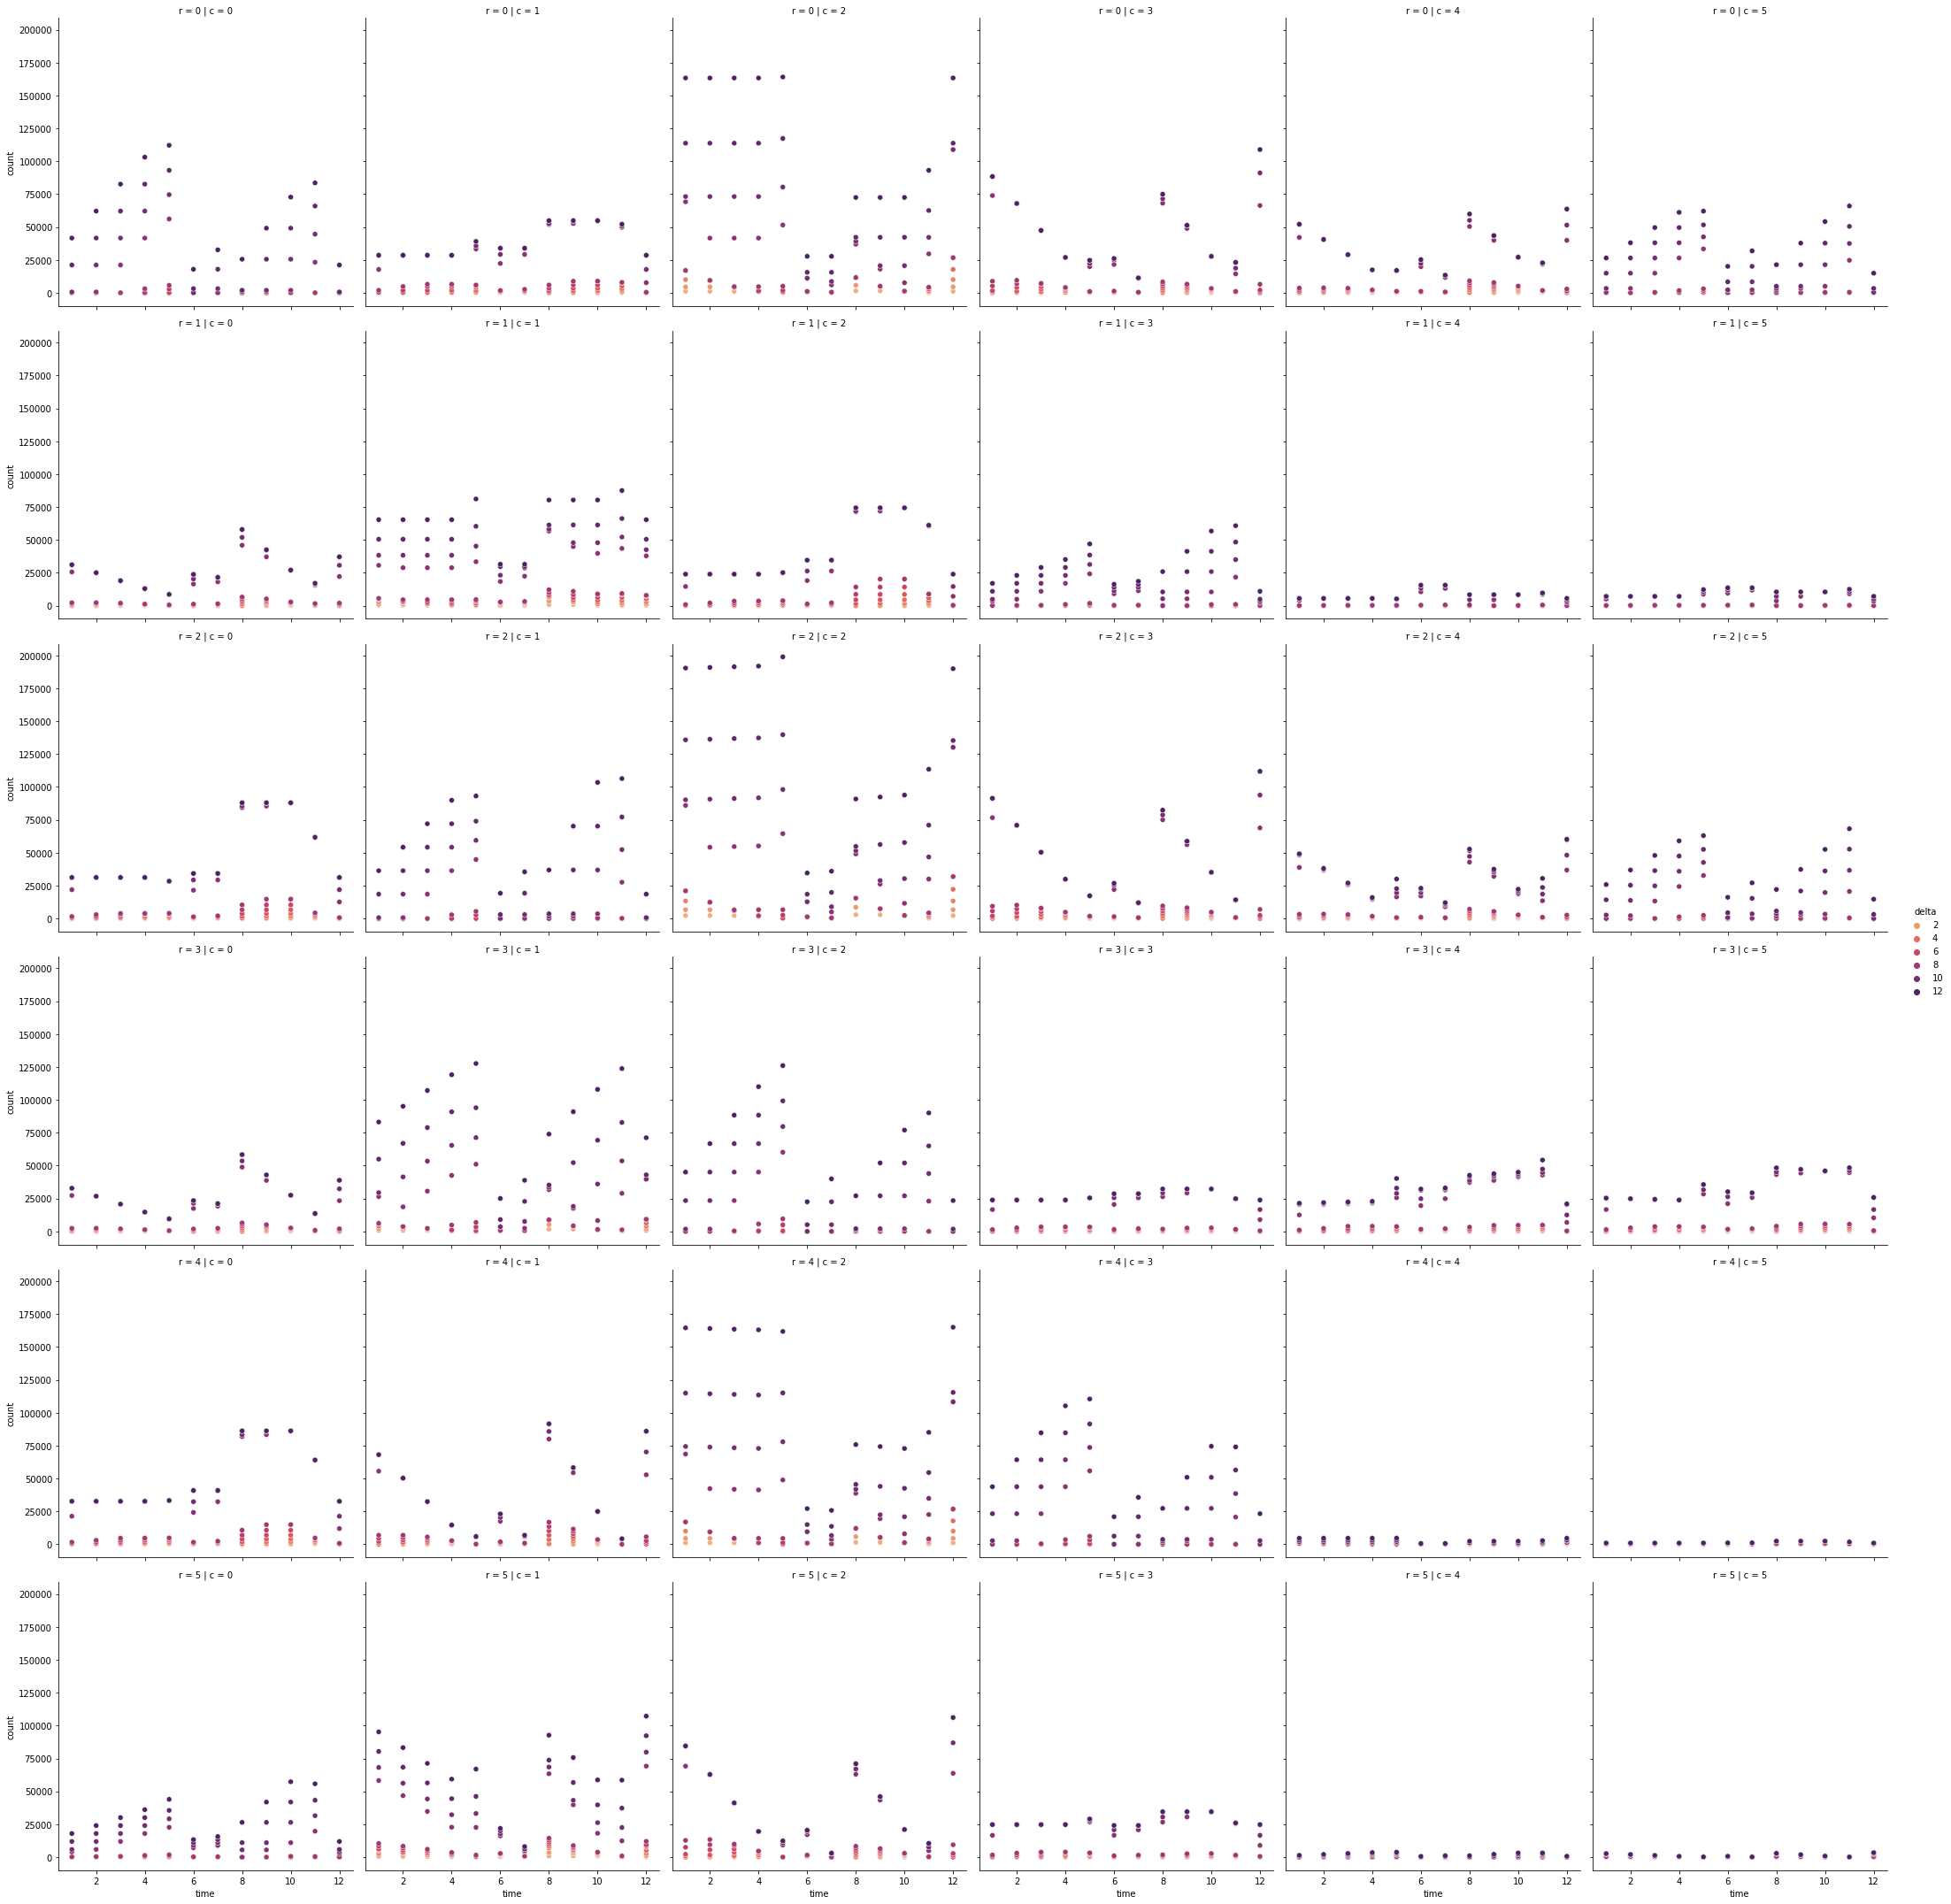

In [9]:
# now, use relplot to plot temporal motif counts for all motifs

# OLD stuff below
# graph = sns.FacetGrid(df_times, col='motif', hue='delta')
# graph.map_dataframe(sns.scatterplot, x='time', y='count')
# graph.add_legend()

# NEW
graph = sns.relplot(data=df_times, x='time', y='count', hue='delta', col='c', row='r', palette=sns.color_palette("flare", as_cmap=True))